# Deep Dive into Matrix Factorization for Recommender Systems

**Author**: Elias Abou Haydar

This notebook accompanies the third post in the recommender systems series, demonstrating Matrix Factorization implementation and concepts.

## Table of Contents
1. Setup and Dependencies
2. Synthetic Data Generation
3. Matrix Factorization Implementation
4. Model Training and Evaluation
5. Results Visualization

## 1. Setup and Dependencies

In [1]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
%matplotlib inline

## 2. Synthetic Data Generation

In [2]:
def generate_interaction_matrix(feedback_type='implicit', num_users=100, num_items=50, 
                              interaction_density=0.1, rating_scale=(1, 5)):
    """Generate synthetic user-item interaction matrices.
    
    Args:
        feedback_type (str): Type of feedback ('implicit' or 'explicit')
        num_users (int): Number of users
        num_items (int): Number of items
        interaction_density (float): Density of interactions (0-1)
        rating_scale (tuple): Range for ratings (min, max)
        
    Returns:
        np.ndarray: Generated interaction matrix
    """
    if feedback_type == 'implicit':
        # Create binary interaction matrix
        random_matrix = np.random.rand(num_users, num_items)
        return (random_matrix < interaction_density).astype(int)
    else:
        # Create explicit rating matrix
        matrix = np.zeros((num_users, num_items))
        for i in range(num_users):
            for j in range(num_items):
                if np.random.rand() < interaction_density:
                    matrix[i, j] = np.random.randint(rating_scale[0], rating_scale[1] + 1)
        return matrix

In [3]:
# Generate example matrices
implicit_matrix = generate_interaction_matrix(feedback_type='implicit')
explicit_matrix = generate_interaction_matrix(feedback_type='explicit')

# Display samples and basic statistics
print("Implicit Feedback Matrix:")
print("Shape:", implicit_matrix.shape)
print("Sample (5x5):")
print(implicit_matrix[:5, :5])
print("\nDensity: {:.2%}".format(np.count_nonzero(implicit_matrix) / implicit_matrix.size))

print("\nExplicit Feedback Matrix:")
print("Shape:", explicit_matrix.shape)
print("Sample (5x5):")
print(explicit_matrix[:5, :5])
print("\nDensity: {:.2%}".format(np.count_nonzero(explicit_matrix) / explicit_matrix.size))
print("Rating distribution:", np.unique(explicit_matrix[explicit_matrix > 0], return_counts=True))

Implicit Feedback Matrix:
Shape: (100, 50)
Sample (5x5):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]

Density: 10.50%

Explicit Feedback Matrix:
Shape: (100, 50)
Sample (5x5):
[[0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 0.]]

Density: 10.06%
Rating distribution: (array([1., 2., 3., 4., 5.]), array([ 96,  97, 108, 106,  96]))


## 3. Matrix Factorization Implementation

In [4]:
def sgd_als(user_item_matrix, num_factors=3, learning_rate=0.001, 
            regularization=0.1, iterations=100, verbose=True):
    """Implement matrix factorization using SGD-optimized ALS.
    
    Args:
        user_item_matrix (np.ndarray): User-item interaction matrix
        num_factors (int): Number of latent factors
        learning_rate (float): Learning rate for SGD
        regularization (float): Regularization parameter
        iterations (int): Number of iterations
        verbose (bool): Whether to print progress
        
    Returns:
        tuple: (user_factors, item_factors, errors)
    """
    # Get matrix dimensions
    num_users, num_items = user_item_matrix.shape
    errors = []
    
    # Initialize factor matrices with small random values
    user_factors = np.random.normal(scale=1./num_factors, 
                                  size=(num_users, num_factors))
    item_factors = np.random.normal(scale=1./num_factors, 
                                  size=(num_items, num_factors))
    
    # Get indices of non-zero elements
    user_item_indices = np.where(user_item_matrix > 0)
    
    # Iterate
    for iteration in range(iterations):
        # Shuffle indices
        indices = np.arange(len(user_item_indices[0]))
        np.random.shuffle(indices)
        
        total_error = 0
        
        # Update factors for non-zero elements
        for idx in indices:
            u, i = user_item_indices[0][idx], user_item_indices[1][idx]
            
            # Compute error
            error = user_item_matrix[u, i] - np.dot(user_factors[u], item_factors[i])
            total_error += error ** 2
            
            # Update user and item factors
            user_grad = error * item_factors[i] - regularization * user_factors[u]
            item_grad = error * user_factors[u] - regularization * item_factors[i]
            
            user_factors[u] += learning_rate * user_grad
            item_factors[i] += learning_rate * item_grad
        
        # Compute RMSE
        rmse = np.sqrt(total_error / len(indices))
        errors.append(rmse)
        
        if verbose and (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: RMSE = {rmse:.4f}")
    
    return user_factors, item_factors, errors

In [5]:
def predict(user_factors, item_factors):
    """Generate predictions from factorized matrices.
    
    Args:
        user_factors (np.ndarray): User latent factors
        item_factors (np.ndarray): Item latent factors
        
    Returns:
        np.ndarray: Predicted ratings
    """
    return np.dot(user_factors, item_factors.T)

## 4. Model Training and Evaluation

Training matrix factorization model...
Iteration 10: RMSE = 3.3158
Iteration 20: RMSE = 3.3022
Iteration 30: RMSE = 3.1991
Iteration 40: RMSE = 2.4407
Iteration 50: RMSE = 1.5568
Iteration 60: RMSE = 1.3708
Iteration 70: RMSE = 1.3089
Iteration 80: RMSE = 1.2697
Iteration 90: RMSE = 1.2376
Iteration 100: RMSE = 1.2074
Iteration 110: RMSE = 1.1780
Iteration 120: RMSE = 1.1485
Iteration 130: RMSE = 1.1196
Iteration 140: RMSE = 1.0898
Iteration 150: RMSE = 1.0610
Iteration 160: RMSE = 1.0328
Iteration 170: RMSE = 1.0058
Iteration 180: RMSE = 0.9796
Iteration 190: RMSE = 0.9552
Iteration 200: RMSE = 0.9318


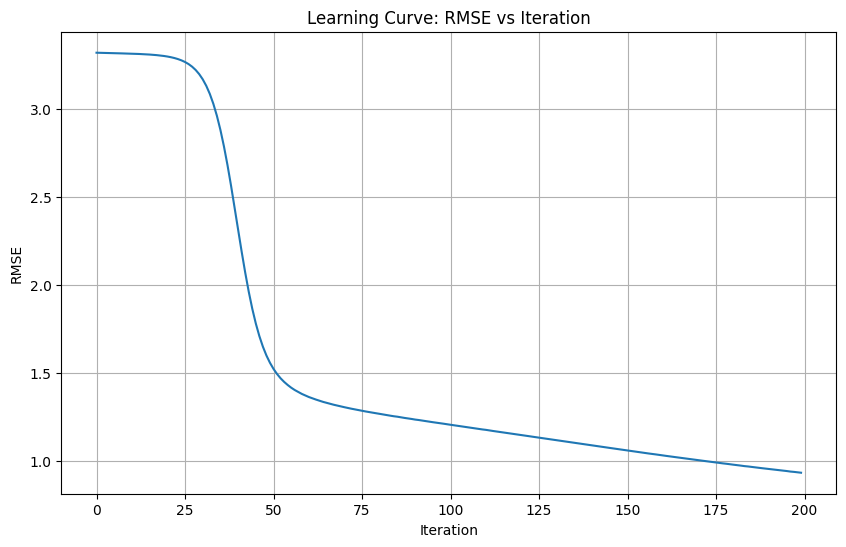

In [6]:
# Train model on explicit feedback matrix
explicit_matrix = generate_interaction_matrix(feedback_type='explicit', num_users=10000, num_items=100, interaction_density=0.05)
print("Training matrix factorization model...")
user_factors, item_factors, errors = sgd_als(
    explicit_matrix,
    num_factors=10,
    learning_rate=0.001,
    regularization=0.1,
    iterations=200
)

# Generate predictions
predictions = predict(user_factors, item_factors)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.title('Learning Curve: RMSE vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## 5. Results Visualization

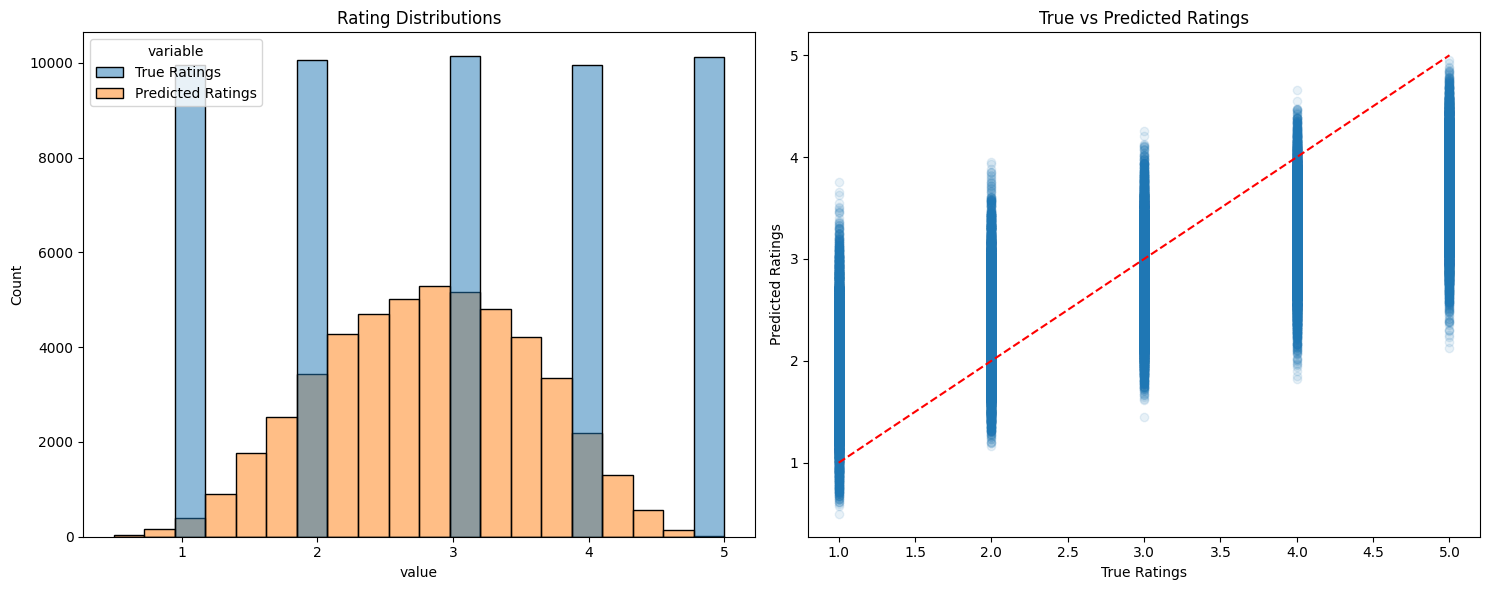

RMSE: 0.9263
MAE: 0.7707


In [7]:
def visualize_results(true_matrix, predicted_matrix):
    """Visualize comparison between true and predicted ratings."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Only consider non-zero elements from true matrix
    mask = true_matrix > 0
    true_ratings = true_matrix[mask]
    pred_ratings = predicted_matrix[mask]
    
    # Distribution plot
    sns.histplot(data=pd.DataFrame({
        'True Ratings': true_ratings,
        'Predicted Ratings': pred_ratings
    }).melt(), x='value', hue='variable', bins=20, ax=ax1)
    ax1.set_title('Rating Distributions')
    
    # Scatter plot
    ax2.scatter(true_ratings, pred_ratings, alpha=0.1)
    ax2.plot([1, 5], [1, 5], 'r--')
    ax2.set_xlabel('True Ratings')
    ax2.set_ylabel('Predicted Ratings')
    ax2.set_title('True vs Predicted Ratings')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
    mae = np.mean(np.abs(true_ratings - pred_ratings))
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# Visualize results
visualize_results(explicit_matrix, predictions)

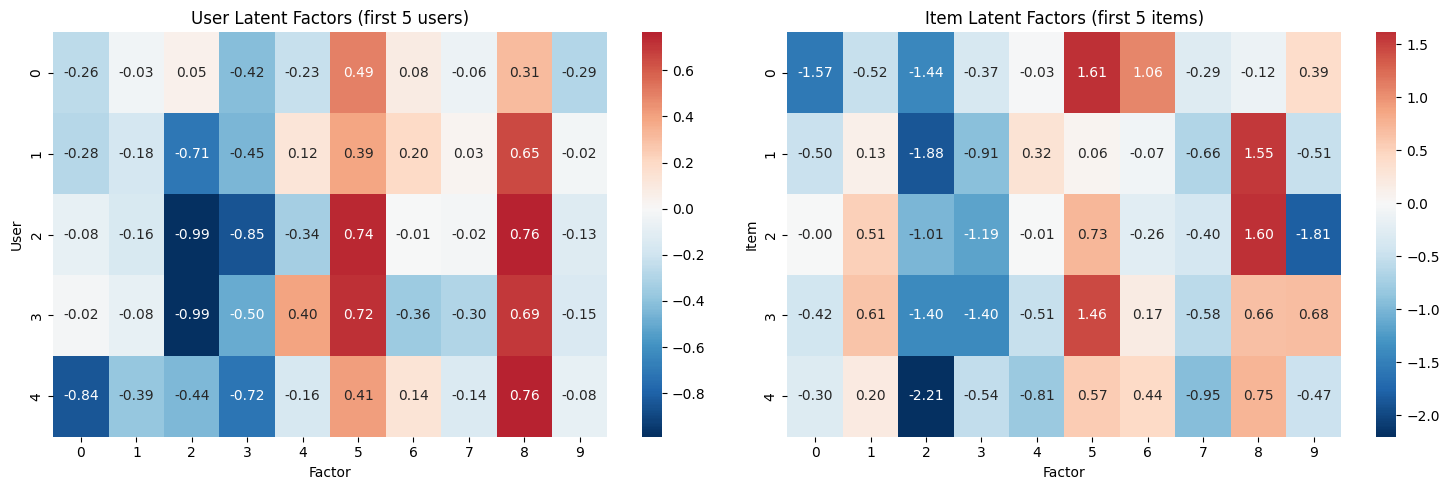

In [8]:
def analyze_latent_factors(user_factors, item_factors, n_users=5, n_items=5):
    """Analyze and visualize latent factors."""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(user_factors[:n_users], 
                cmap='RdBu_r',
                center=0,
                annot=True,
                fmt='.2f')
    plt.title(f'User Latent Factors (first {n_users} users)')
    plt.xlabel('Factor')
    plt.ylabel('User')
    
    plt.subplot(122)
    sns.heatmap(item_factors[:n_items],
                cmap='RdBu_r',
                center=0,
                annot=True,
                fmt='.2f')
    plt.title(f'Item Latent Factors (first {n_items} items)')
    plt.xlabel('Factor')
    plt.ylabel('Item')
    
    plt.tight_layout()
    plt.show()

# Analyze latent factors
analyze_latent_factors(user_factors, item_factors)

## Conclusion

In this notebook, we've implemented and explored Matrix Factorization for recommender systems using SGD-optimized ALS. We covered:

1. Generating synthetic data for testing both implicit and explicit feedback scenarios
2. Implementing matrix factorization with SGD optimization
3. Training the model and visualizing the learning process through RMSE curves
4. Analyzing predictions through distribution and scatter plots
5. Visualizing the learned latent factors to understand the model's internal representation

Key takeaways from this implementation:
- Matrix Factorization effectively reduces the dimensionality of the user-item interaction matrix
- The SGD optimization helps in finding optimal latent factors efficiently
- Regularization helps prevent overfitting and improves model generalization
- Visualization of latent factors can provide insights into user preferences and item characteristics

Future improvements could include:
- Implementing bias terms for users and items
- Adding support for implicit feedback weighting
- Incorporating temporal dynamics
- Implementing additional evaluation metrics
- Testing with real-world datasets like MovieLens

This implementation serves as a foundation for understanding more complex recommender system algorithms and can be extended for various practical applications.

For more details about Matrix Factorization and its applications in recommender systems, refer to the accompanying blog post in the series.